In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c neurips-open-polymer-prediction-2025
!unzip /content/neurips-open-polymer-prediction-2025.zip
!rm /content/neurips-open-polymer-prediction-2025.zip

Mounted at /content/drive
  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 591MB/s]
Archive:  /content/neurips-open-polymer-prediction-2025.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_supplement/dataset1.csv  
  inflating: train_supplement/dataset2.csv  
  inflating: train_supplement/dataset3.csv  
  inflating: train_supplement/dataset4.csv  


In [4]:
%%capture
# !pip install autogluon.tabular[all]
!pip install optuna
!pip install rdkit
!pip install torch-molecule

## Import Packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif

# from autogluon.tabular import TabularDataset, TabularPredictor

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint

## Load Data

In [5]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [6]:
train1 = pd.read_csv('/content/train_supplement/dataset1.csv')
train1 = train1.rename(columns = {'TC_mean': 'Tc'}).head()
# train2 = pd.read_csv('/content/train_supplement/dataset2.csv', index_col = 0)
train3 = pd.read_csv('/content/train_supplement/dataset3.csv')
train4 = pd.read_csv('/content/train_supplement/dataset4.csv')

In [7]:
train = pd.concat([train, train1, train3, train4], axis = 0)
train = train.drop_duplicates(subset = 'SMILES', keep='last')

In [8]:
train.SMILES.nunique(), train.shape

(8882, (8882, 6))

In [9]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
train.shape, test.shape, sub.shape, train1.shape, train3.shape,train4.shape,

((8882, 6), (3, 1), (3, 6), (5, 2), (46, 2), (862, 2))

In [ ]:
sub

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,0,0,0,0,0
1,1422188626,0,0,0,0,0
2,2032016830,0,0,0,0,0


## EDA

In [ ]:
train.head()

,SMILES,Tg,FFV,Tc,Density,Rg
87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [ ]:
test.head()

,SMILES
id,
1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


### Missing Values Check

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))#[0]

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column in target:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"
    else:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    # else:
    #     test_missing = "NA"
    #     unique_values_count_test = "NA"
        # unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,SMILES,object,0.0,0.0,1.0000,8882,3,99.97
1,Tg,float64,93.7,NA,0.0626,556,NA,NA
2,FFV,float64,11.1,NA,0.8844,7855,NA,NA
3,Tc,float64,91.7,NA,0.0561,498,NA,NA
4,Density,float64,93.1,NA,0.0687,610,NA,NA
5,Rg,float64,93.1,NA,0.0688,611,NA,NA


In [ ]:
train1.isna().sum()

,0
TC_mean,0


In [ ]:
train3.isna().sum()

,0
Tg,0


In [ ]:
train4.isna().sum()

,0
FFV,0


In [ ]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


### Plots

In [ ]:
regression =  True#train[target].nunique() > 10
target = 'FFV'

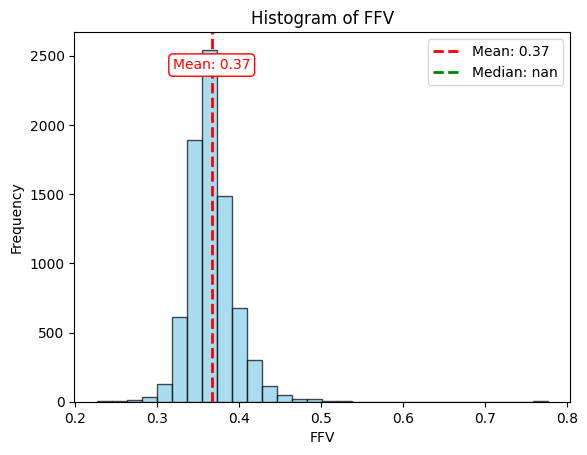

In [ ]:
if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

In [ ]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

#### Numeric

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

else:
  classes = train[target].unique()

  for col in numeric_cols:
    plt.figure(figsize=(10, 6))

    # Gather data grouped by target
    data_to_plot = [train[train[target] == tgt][col].values for tgt in classes]

    # Create boxplot and get the dictionary of plot elements
    box = plt.boxplot(data_to_plot, labels=classes)

    # Annotate the median values
    for i, median_line in enumerate(box['medians']):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]  # both y[0] and y[1] are the same for a horizontal line
        plt.text(x[0], median_value, f'{median_value:.2f}',
                ha='center', va='bottom', fontsize=9, color='blue')

    plt.title(f'Boxplot of {col} by {target}')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  corr = train[numeric_cols + [target]].corr()
  plt.figure(figsize = (10, 8), dpi = 300)
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
  plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
  plt.show()

else:
  X = train[numeric_cols].fillna(-999)
  y = train[target]

  # Compute ANOVA F-value
  f_vals, p_vals = f_classif(X, y)

  # Create DataFrame
  anova_df = pd.DataFrame({
      'Feature': X.columns.tolist(),
      'F_value': f_vals,
      'p_value': p_vals
  }).sort_values('F_value', ascending=False)

  # Plot
  plt.figure(figsize=(10, 6))
  plt.barh(anova_df['Feature'], anova_df['F_value'], color='skyblue')
  plt.xlabel('ANOVA F-value')
  plt.title('ANOVA Feature Importance for Multiclass Target')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

#### Categorical

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

else:
  for col in categorical_cols:
    crosstab = pd.crosstab(train[col], train[target], normalize='index')  # row-wise percent
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Distribution of {target} by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

else:
  chi2_results = {}

  # Encode the multiclass target
  y_encoded = LabelEncoder().fit_transform(train[target])

  for col in categorical_cols:
      # Encode the categorical feature
      x_encoded = LabelEncoder().fit_transform(train[col]).reshape(-1, 1)

      # Run chi-squared test
      stat, p = chi2(x_encoded, y_encoded)
      chi2_results[col] = {"Chi2 Statistic": stat[0], "p-value": p[0]}

  # Convert to DataFrame
  chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")
  display(chi2_df.sort_values(by="Chi2 Statistic", ascending=False))

### Unique

In [ ]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


In [ ]:
train[train['FFV'] >= 0.5]

,SMILES,Tg,FFV,Tc,Density,Rg
177272960,*c1ccc(*)[nH]1,NaN,0.563897,NaN,NaN,NaN
180321996,*CCCCCCCCCC[N+](*)(C)C,NaN,0.769315,NaN,NaN,NaN
370833911,*CCSSSS*,NaN,0.528203,NaN,NaN,NaN
637669265,*CC(*)C(=O)NCCC[N+](C)(C)C,NaN,0.687057,NaN,NaN,NaN
660253930,*c1ccc(-c2sc(-c3ccc(-c4cc(CCCC)c(*)s4)cc3)cc2C...,NaN,0.500778,NaN,NaN,NaN
713393124,*CC(*)C(=O)N1CC[NH+](CC)CC1,NaN,0.650907,NaN,NaN,NaN
750049504,*c1ccc(-c2sc(-c3ccc(-c4cc(SCCCC)c(*)s4)cc3)cc2...,NaN,0.511978,NaN,NaN,NaN
806978622,*CC(*)O[N+](=O)[O-],NaN,0.774066,0.1585,1.305302,17.272314
852184111,*c1cc(C)c(*)s1,NaN,0.516864,NaN,NaN,NaN
1201617221,*c1ccc(-c2sc(-c3cc(SCCCC)c(*)s3)cc2SCCCC)cc1,NaN,0.507618,NaN,NaN,NaN


## Feature Egnineering RDKIT

In [ ]:
# A small function to handle potential errors with invalid SMILES strings.
def smiles_to_features(smiles_string, n_bits=1024):
    """
    Takes a SMILES string and returns a dictionary of RDKit molecular
    descriptors and Morgan fingerprints.
    """
    try:
        # Create a molecule object from the SMILES string
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return None # Return None for invalid SMILES

        # Calculate a variety of molecular descriptors
        features = {
            'MolWt': Descriptors.MolWt(mol),
            'ExactMolWt': Descriptors.ExactMolWt(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            'NumAromaticRings': Descriptors.NumAromaticRings(mol),
            'TPSA': Descriptors.TPSA(mol),
            'BalabanJ': Descriptors.BalabanJ(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
            'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
        }

        # Generate Morgan fingerprints using the modern MorganGenerator
        # The MorganGenerator is the recommended way to generate fingerprints.
        # It's more efficient and flexible.
        gen = GetMorganGenerator(radius=2, fpSize=n_bits)
        morgan_fp = gen.GetFingerprint(mol).ToBitString()

        # Add the fingerprint as a new column. We store it as a string to simplify the DataFrame.
        # It can be converted back to an array for modeling later.
        features['MorganFP'] = morgan_fp

        return features

    except Exception as e:
        print(f"Error processing SMILES '{smiles_string}': {e}")
        return None

In [ ]:
rdk_feats = pd.DataFrame(train['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=train.index)

In [ ]:
train = pd.concat([train, rdk_feats], axis = 1)

In [ ]:
rdk_feats_test = pd.DataFrame(test['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=test.index)
test = pd.concat([test, rdk_feats_test ], axis = 1)

In [ ]:
def expand_and_reduce_morgan_fp(df_train, df_test, fp_col="MorganFP", n_components=50):
    """
    Expands a MorganFP bitstring column into bits,
    then applies PCA to reduce dimensionality.
    Returns updated train and test DataFrames.
    """
    # Convert bitstrings to numpy arrays
    def bitstring_to_array(fp):
        if isinstance(fp, str):
            if set(fp) <= {"0", "1"} and len(fp) > 10:
                return np.array(list(fp), dtype=int)
            else:
                return np.fromstring(fp.strip("[]"), sep=",", dtype=int)
        else:
            return np.array(fp, dtype=int)

    train_bits = np.array([bitstring_to_array(fp) for fp in df_train[fp_col]])
    test_bits = np.array([bitstring_to_array(fp) for fp in df_test[fp_col]])

    # PCA reduction
    pca = PCA(n_components=n_components, random_state=42)
    train_reduced = pca.fit_transform(train_bits)
    test_reduced = pca.transform(test_bits)

    # Create DataFrames for PCA features
    fp_cols = [f"fp_pca_{i}" for i in range(train_reduced.shape[1])]
    train_fp_df = pd.DataFrame(train_reduced, index=df_train.index, columns=fp_cols)
    test_fp_df = pd.DataFrame(test_reduced, index=df_test.index, columns=fp_cols)

    # Drop original FP column and add reduced PCA features
    df_train = pd.concat([df_train.drop(columns=[fp_col]), train_fp_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=[fp_col]), test_fp_df], axis=1)

    return df_train, df_test

# Example usage:
train, test = expand_and_reduce_morgan_fp(train, test, fp_col="MorganFP", n_components=50)

In [ ]:
train.head()

,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,ExactMolWt,NumRotatableBonds,NumAromaticRings,...,fp_pca_40,fp_pca_41,fp_pca_42,fp_pca_43,fp_pca_44,fp_pca_45,fp_pca_46,fp_pca_47,fp_pca_48,fp_pca_49
87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,232.323,232.146330,8,1,...,0.009586,-0.642413,-0.776641,0.186512,-0.101393,-0.792276,0.495031,0.191727,-0.522032,0.058803
106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,598.919,598.428700,16,4,...,0.200567,0.220709,-0.290066,-0.442352,0.344877,0.347644,0.205360,0.014267,0.751661,0.282390
388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,1003.207,1002.289625,15,8,...,0.103521,0.729177,-0.368731,-0.120965,0.559373,-0.089752,-0.348275,-0.506540,0.389508,0.291084
519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,542.726,542.272199,7,6,...,-0.217287,-0.046334,0.159358,-0.111365,0.347734,-0.032330,-0.512607,0.305540,-0.297923,-0.131560
539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,965.154,964.483374,34,4,...,0.956717,1.031880,0.484171,0.223160,-0.378003,-1.070701,0.620123,0.112412,0.133197,0.621752


## Tree Models

#### HGBG

In [ ]:
cols_to_fit = ['MolWt', 'ExactMolWt',
       'NumRotatableBonds', 'NumAromaticRings', 'TPSA', 'BalabanJ',
       'NumHDonors', 'NumHAcceptors', 'HeavyAtomCount', 'NumHeteroatoms',
      #  'MorganFP',
               'fp_pca_1', 'fp_pca_2','fp_pca_3','fp_pca_4','fp_pca_5'

               ]
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [ ]:
# Store results
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]

    # Define the model
    model = HistGradientBoostingRegressor(random_state=42)

    # MSE scorer (negative because sklearn expects higher=better)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

    # Store positive MSE values
    cv_results[target] = -scores  # convert back to positive MSE

# Display results
for target, mse_scores in cv_results.items():
    print(f"Target: {target}")
    print(f"  Fold MSEs: {mse_scores}")
    print(f"  Mean MSE: {np.mean(mse_scores):.4f}")
    print("-" * 40)

Target: Tg
  Fold MSEs: [4708.88756424 6143.05692646 5546.89291005 4164.54097189 4163.8278088 ]
  Mean MSE: 4945.4412
----------------------------------------
Target: FFV
  Fold MSEs: [0.0002686  0.00020338 0.00027029 0.00033884 0.00032883]
  Mean MSE: 0.0003
----------------------------------------
Target: Tc
  Fold MSEs: [0.0022053  0.00151207 0.00271136 0.0022612  0.00223384]
  Mean MSE: 0.0022
----------------------------------------
Target: Density
  Fold MSEs: [0.00689609 0.01134365 0.00413321 0.00399622 0.00395575]
  Mean MSE: 0.0061
----------------------------------------
Target: Rg
  Fold MSEs: [ 8.52569002  8.22066033  7.63138631 10.73810514  7.55395084]
  Mean MSE: 8.5340
----------------------------------------


In [ ]:
train[targets].describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


##### Hyp Tune

In [ ]:
# Hyperparameter search space
param_dist = {
    "max_iter": randint(100, 1000),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.2),
    "min_samples_leaf": randint(5, 50),
    "l2_regularization": uniform(0.0, 1.0),
    "max_bins": randint(50, 255)
}

# Results storage
best_params = {}
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]

    model = HistGradientBoostingRegressor(random_state=42)

    # Randomized search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,              # number of random configs to try
        scoring=mse_scorer,
        cv=kf,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X, y)

    # Store results
    best_params[target] = search.best_params_
    cv_results[target] = -search.best_score_  # Convert to positive MSE

# Display results
for target in targets:
    print(f"Target: {target}")
    print(f"  Best Params: {best_params[target]}")
    print(f"  Best Mean MSE (CV): {cv_results[target]:.4f}")
    print("-" * 40)

Target: Tg
  Best Params: {'l2_regularization': np.float64(0.32434502100527396), 'learning_rate': np.float64(0.03441759094013467), 'max_bins': 239, 'max_depth': 3, 'max_iter': 484, 'min_samples_leaf': 31}
  Best Mean MSE (CV): 4718.5289
----------------------------------------
Target: FFV
  Best Params: {'l2_regularization': np.float64(0.25178229582536416), 'learning_rate': np.float64(0.10944970117847709), 'max_bins': 162, 'max_depth': 7, 'max_iter': 724, 'min_samples_leaf': 21}
  Best Mean MSE (CV): 0.0003
----------------------------------------
Target: Tc
  Best Params: {'l2_regularization': np.float64(0.5677003278199915), 'learning_rate': np.float64(0.016262658491111717), 'max_bins': 195, 'max_depth': 4, 'max_iter': 301, 'min_samples_leaf': 40}
  Best Mean MSE (CV): 0.0020
----------------------------------------
Target: Density
  Best Params: {'l2_regularization': np.float64(0.965255307264138), 'learning_rate': np.float64(0.13140684953733694), 'max_bins': 90, 'max_depth': 3, 'max_

#### XGB

In [ ]:
cols_to_fit = ['MolWt', 'ExactMolWt',
       'NumRotatableBonds', 'NumAromaticRings', 'TPSA', 'BalabanJ',
       'NumHDonors', 'NumHAcceptors', 'HeavyAtomCount', 'NumHeteroatoms',
      #  'MorganFP',
               'fp_pca_1', 'fp_pca_2','fp_pca_3','fp_pca_4','fp_pca_5'

               ]
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Store results
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]

    # Define the XGBoost model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",    # fast histogram-based algorithm
        eval_metric="rmse",
        n_jobs=-1
    )

    # MSE scorer (negative for sklearn, will convert back later)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

    # Store positive MSE values
    cv_results[target] = -scores

# Display results
for target, mse_scores in cv_results.items():
    print(f"Target: {target}")
    print(f"  Fold MSEs: {mse_scores}")
    print(f"  Mean MSE: {np.mean(mse_scores):.4f}")
    print("-" * 40)

Target: Tg
  Fold MSEs: [5313.46556885 6898.71889321 5955.45605733 4508.48660029 4033.08558511]
  Mean MSE: 5341.8425
----------------------------------------
Target: FFV
  Fold MSEs: [0.0002492  0.00017657 0.00024821 0.00031338 0.00030722]
  Mean MSE: 0.0003
----------------------------------------
Target: Tc
  Fold MSEs: [0.00252276 0.00143629 0.00262719 0.00185771 0.00196355]
  Mean MSE: 0.0021
----------------------------------------
Target: Density
  Fold MSEs: [0.00665456 0.0084307  0.00380051 0.00329826 0.00319984]
  Mean MSE: 0.0051
----------------------------------------
Target: Rg
  Fold MSEs: [10.44876945  6.21550878  9.01299223 10.67632352  8.27214721]
  Mean MSE: 8.9251
----------------------------------------


##### Hyp Tune

In [ ]:
param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),          # range 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),   # range 0.5–1.0
    "gamma": uniform(0.0, 1.0),
    "reg_alpha": uniform(0.0, 2.0),
    "reg_lambda": uniform(0.0, 2.0)
}

best_params = {}
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

for target in targets:
    # Drop rows with NaN in this target
    df_target = train.dropna(subset=[target])
    X = df_target[cols_to_fit]
    y = df_target[target]

    model = XGBRegressor(
        random_state=42,
        tree_method="hist",
        eval_metric="rmse",
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,              # try 30 random combos
        scoring=mse_scorer,
        cv=kf,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X, y)

    best_params[target] = search.best_params_
    cv_results[target] = -search.best_score_  # back to positive MSE

# Display results
for target in targets:
    print(f"Target: {target}")
    print(f"  Best Params: {best_params[target]}")
    print(f"  Best Mean MSE (CV): {cv_results[target]:.4f}")
    print("-" * 40)

Target: Tg
  Best Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(0.7080725777960455), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 543, 'reg_alpha': np.float64(1.6648852816008435), 'reg_lambda': np.float64(0.4246782213565523), 'subsample': np.float64(0.5909124836035503)}
  Best Mean MSE (CV): 4778.3416
----------------------------------------
Target: FFV
  Best Params: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.0005203769953158188), 'learning_rate': np.float64(0.11577065690025069), 'max_depth': 5, 'n_estimators': 558, 'reg_alpha': np.float64(0.32931170628588347), 'reg_lambda': np.float64(1.068178838750884), 'subsample': np.float64(0.7424149856794916)}
  Best Mean MSE (CV): 0.0003
----------------------------------------
Target: Tc
  Best Params: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.0005203769953158188), 'learning_rate': np.float64(0.1157706569002

## Graph NN

In [10]:
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [11]:
from torch_molecule import GREAMolecularPredictor, GNNMolecularPredictor
from torch_molecule.utils.search import ParameterType, ParameterSpec

# Define search parameters
search_GNN = {
    "gnn_type": ParameterSpec(ParameterType.CATEGORICAL, ["gin-virtual", "gcn-virtual", "gin", "gcn"]),
    "norm_layer": ParameterSpec(ParameterType.CATEGORICAL, ["batch_norm", "layer_norm"]),
    "graph_pooling": ParameterSpec(ParameterType.CATEGORICAL, ["mean", "sum", "max"]),
    "augmented_feature": ParameterSpec(ParameterType.CATEGORICAL, ["maccs,morgan", "maccs", "morgan", None]),
    "num_layer": ParameterSpec(ParameterType.INTEGER, (2, 5)),
    "hidden_size": ParameterSpec(ParameterType.INTEGER, (64, 512)),
    "drop_ratio": ParameterSpec(ParameterType.FLOAT, (0.0, 0.5)),
    "learning_rate": ParameterSpec(ParameterType.LOG_FLOAT, (1e-5, 1e-2)),
    "weight_decay": ParameterSpec(ParameterType.LOG_FLOAT, (1e-10, 1e-3)),
}

search_GREA = {
    "gamma": ParameterSpec(ParameterType.FLOAT, (0.25, 0.75)),
    **search_GNN
}

# Train GREA model
grea_model = GREAMolecularPredictor(
    num_task=1,
    task_type="regression",
    model_name="GREA_multitask",
    batch_size=8,
    epochs=10,
    evaluate_criterion='mse',
    evaluate_higher_better=False,
    verbose=True
)

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
N_TRIALS = 1

# Dictionary to store trained models
best_models = {}

for target in targets:
    print(f"\n=== Training for target: {target} ===")
    df_target = train.dropna(subset=[target])  # drop rows where this target is missing

    smiles = df_target["SMILES"].tolist()
    y = df_target[target].values.reshape(-1, 1)

    fold_models = []
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(smiles), start=1):
        X_train = [smiles[i] for i in train_idx]
        y_train = y[train_idx].tolist()
        X_val = [smiles[i] for i in val_idx]
        y_val = y[val_idx].tolist()

        model = GREAMolecularPredictor(
            num_task=1,
            task_type="regression",
            model_name=f"GREA_{target}_fold{fold}",
            batch_size=8,
            epochs=10,
            evaluate_criterion='mse',
            evaluate_higher_better=False,
            verbose=True
        )

        model.autofit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            n_trials=N_TRIALS,
            search_parameters=search_GREA
        )

        # Save trained fold model
        model_path = f"{target}_fold{fold}.pt"
        model.save_to_local(model_path)
        fold_models.append(model_path)

        # Evaluate on validation set
        preds = model.predict(X_val)
        mse = ((preds - y[val_idx]) ** 2).mean()
        fold_scores.append(mse)
        print(f"Fold {fold} MSE: {mse:.4f}")

    best_models[target] = {
        "fold_models": fold_models,
        "mean_mse": sum(fold_scores) / len(fold_scores)
    }

print("\nTraining complete!")
print(best_models)


=== Training for target: FFV ===


[I 2025-08-13 01:12:39,312] A new study created in memory with name: GREA_FFV_fold1_optimization



Parameter Search Configuration:
--------------------------------------------------

 Parameters being searched:
  • augmented_feature: ['maccs,morgan', 'maccs', 'morgan', None]
  • drop_ratio: [0.0, 0.5]
  • gamma: [0.25, 0.75]
  • gnn_type: ['gin-virtual', 'gcn-virtual', 'gin', 'gcn']
  • graph_pooling: ['mean', 'sum', 'max']
  • hidden_size: [64, 512]
  • learning_rate: [1e-05, 0.01]
  • norm_layer: ['batch_norm', 'layer_norm']
  • num_layer: [2, 5]
  • weight_decay: [1e-10, 0.001]

 Fixed parameters (not being searched):
  • batch_size: 8
  • device: cpu
  • epochs: 10
  • evaluate_criterion: <function mean_squared_error at 0x7c6dce7e1f80>
  • evaluate_higher_better: False
  • evaluate_name: mse
  • fitting_epoch: 0
  • fitting_loss: []
  • grad_clip_value: None
  • loss_criterion: L1Loss()
  • num_task: 1
  • patience: 50
  • scheduler_factor: 0.5
  • scheduler_patience: 5
  • task_type: regression
  • use_lr_scheduler: False
  • verbose: True

------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:18<00:00, 342.07it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:03<00:00, 407.38it/s]

Training: 100%|█████████▉| 789/790 [01:38<00:00,  8.44it/s, Epoch=0, Loss=0.2068]
                                                                                 

[W 2025-08-13 01:14:45,089] Trial 0 failed with parameters: {'gamma': 0.49837193400947505, 'gnn_type': 'gcn-virtual', 'norm_layer': 'batch_norm', 'graph_pooling': 'mean', 'augmented_feature': 'maccs', 'num_layer': 3, 'hidden_size': 241, 'drop_ratio': 0.22517229627998386, 'learning_rate': 3.270232144838261e-05, 'weight_decay': 1.7582231965738483e-07} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 482])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self.


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:22<00:00, 276.14it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:06<00:00, 234.14it/s]

Training: 100%|█████████▉| 788/790 [01:13<00:00, 11.15it/s, Epoch=0, Loss=0.0951]
                                                                                 

[W 2025-08-13 01:16:32,772] Trial 1 failed with parameters: {'gamma': 0.3876556958882668, 'gnn_type': 'gcn-virtual', 'norm_layer': 'layer_norm', 'graph_pooling': 'max', 'augmented_feature': 'maccs,morgan', 'num_layer': 3, 'hidden_size': 138, 'drop_ratio': 0.2857307345599326, 'learning_rate': 0.00042818466033616934, 'weight_decay': 7.795403271223577e-07} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 276])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = s


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:06<00:00, 1029.46it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:01<00:00, 811.49it/s]

Training: 100%|█████████▉| 789/790 [02:14<00:00,  5.89it/s, Epoch=0, Loss=0.2106]
                                                                                 

[W 2025-08-13 01:19:00,352] Trial 2 failed with parameters: {'gamma': 0.5073651621184712, 'gnn_type': 'gin-virtual', 'norm_layer': 'layer_norm', 'graph_pooling': 'mean', 'augmented_feature': None, 'num_layer': 2, 'hidden_size': 263, 'drop_ratio': 0.42759057206892864, 'learning_rate': 0.006519462045158837, 'weight_decay': 8.39941172403351e-06} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 526])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._train_


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:13<00:00, 482.90it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:02<00:00, 578.68it/s]

Training: 100%|█████████▉| 789/790 [04:16<00:00,  3.48it/s, Epoch=0, Loss=0.1214]
                                                                                 

[W 2025-08-13 01:23:36,613] Trial 3 failed with parameters: {'gamma': 0.746684867850822, 'gnn_type': 'gin-virtual', 'norm_layer': 'layer_norm', 'graph_pooling': 'sum', 'augmented_feature': 'morgan', 'num_layer': 3, 'hidden_size': 382, 'drop_ratio': 0.3320129988037717, 'learning_rate': 0.00042346729153868216, 'weight_decay': 7.902007000463039e-10} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 764])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._tr


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:14<00:00, 438.88it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:03<00:00, 432.39it/s]

Training: 100%|█████████▉| 789/790 [05:21<00:00,  2.86it/s, Epoch=0, Loss=0.1270]
                                                                                 

[W 2025-08-13 01:29:19,749] Trial 4 failed with parameters: {'gamma': 0.4362762842415199, 'gnn_type': 'gin-virtual', 'norm_layer': 'batch_norm', 'graph_pooling': 'sum', 'augmented_feature': 'morgan', 'num_layer': 3, 'hidden_size': 464, 'drop_ratio': 0.4158713561741695, 'learning_rate': 0.00034025613729666323, 'weight_decay': 2.1091134512875495e-07} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 928])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:28<00:00, 224.38it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:08<00:00, 184.47it/s]

Training: 100%|█████████▉| 789/790 [06:13<00:00,  1.83it/s, Epoch=0, Loss=0.1727]
                                                                                 

[W 2025-08-13 01:36:15,042] Trial 5 failed with parameters: {'gamma': 0.6306185502681247, 'gnn_type': 'gin-virtual', 'norm_layer': 'batch_norm', 'graph_pooling': 'mean', 'augmented_feature': 'maccs,morgan', 'num_layer': 4, 'hidden_size': 452, 'drop_ratio': 0.30515705071796845, 'learning_rate': 3.643023850435931e-05, 'weight_decay': 1.2140332327555029e-05} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 904])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses =


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:25<00:00, 246.08it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:05<00:00, 300.49it/s]

Training: 100%|█████████▉| 789/790 [02:21<00:00,  6.00it/s, Epoch=0, Loss=0.0426]
                                                                                 

[W 2025-08-13 01:39:10,985] Trial 6 failed with parameters: {'gamma': 0.5252962518638535, 'gnn_type': 'gcn', 'norm_layer': 'layer_norm', 'graph_pooling': 'sum', 'augmented_feature': 'maccs', 'num_layer': 3, 'hidden_size': 379, 'drop_ratio': 0.18121934702872966, 'learning_rate': 0.002304955606108693, 'weight_decay': 1.98702858430873e-06} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 758])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._train_epoch(


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:17<00:00, 363.98it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:04<00:00, 389.80it/s]

Training: 100%|█████████▉| 789/790 [01:36<00:00,  8.12it/s, Epoch=0, Loss=0.2898]
                                                                                 

[W 2025-08-13 01:41:14,472] Trial 7 failed with parameters: {'gamma': 0.39759537077416984, 'gnn_type': 'gcn-virtual', 'norm_layer': 'layer_norm', 'graph_pooling': 'mean', 'augmented_feature': 'morgan', 'num_layer': 3, 'hidden_size': 191, 'drop_ratio': 0.1195451487591655, 'learning_rate': 1.2728255945203461e-05, 'weight_decay': 1.732830564327026e-10} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 382])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self.


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:27<00:00, 230.66it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:06<00:00, 238.69it/s]

Training: 100%|█████████▉| 789/790 [07:33<00:00,  1.70it/s, Epoch=0, Loss=0.0635]
                                                                                 

[W 2025-08-13 01:49:29,001] Trial 8 failed with parameters: {'gamma': 0.4380556155092156, 'gnn_type': 'gin', 'norm_layer': 'layer_norm', 'graph_pooling': 'mean', 'augmented_feature': 'maccs', 'num_layer': 5, 'hidden_size': 472, 'drop_ratio': 0.4078130521012724, 'learning_rate': 0.0002297407462981408, 'weight_decay': 2.7709854033714612e-08} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 944])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._train_epo


Converting molecules to graphs: 100%|██████████| 6313/6313 [00:26<00:00, 235.53it/s]

Converting molecules to graphs: 100%|██████████| 1579/1579 [00:06<00:00, 237.26it/s]

Training: 100%|█████████▉| 789/790 [01:44<00:00,  7.91it/s, Epoch=0, Loss=0.0980]
                                                                                 

[W 2025-08-13 01:51:52,624] Trial 9 failed with parameters: {'gamma': 0.7005757011595884, 'gnn_type': 'gcn', 'norm_layer': 'layer_norm', 'graph_pooling': 'sum', 'augmented_feature': 'maccs', 'num_layer': 4, 'hidden_size': 253, 'drop_ratio': 0.22610745510454228, 'learning_rate': 0.006213997349964425, 'weight_decay': 2.9737296582198846e-05} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 506])').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 387, in objective
    self.fit(X_train, y_train, X_val, y_val, X_unlbl)
  File "/usr/local/lib/python3.11/dist-packages/torch_molecule/predictor/gnn/modeling_gnn.py", line 548, in fit
    train_losses = self._train_epoc

ValueError: Model must be fitted before saving to local disk.

In [14]:
best_models

{}

## Save to Github

In [15]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "NeuralIPS-Open-Polymer"
username = "abishpius"
message = "added HGBG and XGB hyp tune models"
notebook_name = "Kaggle_NerualIPS_Open_Polymer.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'NeuralIPS-Open-Polymer' already exists at: https://github.com/abishpius/NeuralIPS-Open-Polymer


In [17]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "added GNN model tuning code"
!git push

Cloning into '{repo_name}'...
remote: Repository not found.
fatal: repository 'https://github.com/{username}/{repo_name}.git/' not found


NameError: name 'notebook_name' is not defined